# Imports

In [1]:
import pandas as pd
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
import random
from datetime import datetime
import uuid
import json
import os
import gdown

# Set the directory where the datasets will be saved

In [2]:
datasets_path = '../../data/benchmark_datasets/'

## Load RFAM dataframe and run CD-HIT

### Function definition

In [3]:
def cluster_sequences(df, identity_threshold=0.9, num_threads=1, memory=800):
    """
    Cluster RNA sequences to remove redundancy using CD-HIT.

    Parameters:
        df (pd.DataFrame): DataFrame with a "sequence" column containing RNA sequences.
        identity_threshold (float): Identity threshold for clustering (default is 0.9).
        num_threads (int): Number of threads (cores) to use for CD-HIT (default is 1).

    Returns:
        pd.DataFrame: Filtered DataFrame with one representative sequence per cluster.
    """
    # Step 1: Export sequences to a FASTA file
    fasta_file = "sequences.fasta"
    clustered_fasta = "sequences_clustered.fasta"
    with open(fasta_file, "w") as f:
        for i, sequence in enumerate(df["sequence"]):
            f.write(f">seq{i}\n{sequence}\n")
    
    # Step 2: Run CD-HIT
    subprocess.run([
        "cd-hit",
        "-i", fasta_file,
        "-o", clustered_fasta,
        "-c", str(identity_threshold),  # Set the identity threshold
        "-T", str(num_threads), # Set the number of threads
        "-M" , str(memory)
    ], check=True)
    
    # Step 3: Parse CD-HIT output and filter the DataFrame
    representative_sequences = set()
    with open(clustered_fasta, "r") as f:
        for line in f:
            if line.startswith(">"):
                representative_sequences.add(line.strip()[1:])  # Extract sequence ID
    
    # Map IDs back to the original DataFrame
    keep_indices = [int(seq_id[3:]) for seq_id in representative_sequences]
    filtered_df = df.iloc[keep_indices]
    
    return filtered_df


### Download the rfam dataset from gdrive and load it

In [4]:
url = 'https://drive.google.com/uc?id=1NkEKF8i-kaGsbsvQ9l97mRDIHv-WaJhS'
rfam_dataset_path = datasets_path + 'rfam_dataset.csv'
gdown.download(url, rfam_dataset_path, quiet=False)
rfam_df = pd.read_csv(rfam_dataset_path)

Downloading...
From (original): https://drive.google.com/uc?id=1NkEKF8i-kaGsbsvQ9l97mRDIHv-WaJhS
From (redirected): https://drive.google.com/uc?id=1NkEKF8i-kaGsbsvQ9l97mRDIHv-WaJhS&confirm=t&uuid=721f3e48-3388-45ab-ad60-81f5b559d1dd
To: /home/nicolas/programs/StrusiNet2/data/benchmark_datasets/rfam_dataset.csv
100%|██████████| 478M/478M [00:07<00:00, 63.0MB/s] 


### (Option 1) Run cd-hit and save the resulting clustered dataset

In [39]:
# identity_threshold = 0.9  # Set the desired identity threshold
# num_threads = 0  # Specify the number of CPU cores to use
# memory = 16384
# rfam_df = cluster_sequences(rfam_df, identity_threshold, num_threads, memory)
# output_clustered_path = datasets_path + '/filtered_rfam_90.csv'
# rfam_df.to_csv(output_clustered_path)

### (Option 2) Download the clustered dataset from gdrive

In [3]:
url_clustered = 'https://drive.google.com/uc?id=1s4tsCGdnqmRYbwOQCiXw3UfQ_rGZiojF'
output_clustered_path = datasets_path + 'filtered_rfam_90.csv'
gdown.download(url_clustered, output_clustered_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1s4tsCGdnqmRYbwOQCiXw3UfQ_rGZiojF
From (redirected): https://drive.google.com/uc?id=1s4tsCGdnqmRYbwOQCiXw3UfQ_rGZiojF&confirm=t&uuid=981c9594-2a5a-47c2-ac98-33f18bc89d8f
To: /home/nicolas/programs/StrusiNet2/data/benchmark_datasets/filtered_rfam_90.csv
100%|██████████| 148M/148M [00:02<00:00, 69.7MB/s] 


'../../data/benchmark_datasets/filtered_rfam_90.csv'

### Load the clustered dataset (overwrite the original rfam_df to save memory)

In [4]:
rfam_df = pd.read_csv(output_clustered_path)

# Data cleaning

In [5]:
### There are some RFAMs with multiple rna_type, this part of the code
### will find the RFAMs shared by multiple rna_types and force the 
### rna_type to be the most common. 

rfam_df['rfam'] = rfam_df['rfam'].astype('category')

# Step 1: Identify `rfam` with multiple `rna_type` and their counts
rfam_type_counts = rfam_df.groupby(['rfam', 'rna_type'], observed=False).size().reset_index(name='count')

# Step 2: Determine the most common `rna_type` for each `rfam`
most_common_rna_type = rfam_type_counts.loc[
    rfam_type_counts.groupby('rfam', observed=False)['count'].idxmax()
].set_index('rfam')['rna_type']

# Step 3: Merge the most common `rna_type` back into the dataframe
rfam_df = rfam_df.merge(most_common_rna_type, on='rfam', how='left', suffixes=('', '_most_common'))

# Step 4: Update the `rna_type` if it's not the most common one
rfam_df['forced_rna_type'] = (rfam_df['rna_type'] != rfam_df['rna_type_most_common']).astype(int)
rfam_df['rna_type'] = rfam_df['rna_type_most_common']

# Step 5: Drop the helper column
rfam_df.drop(columns=['rna_type_most_common'], inplace=True)

### Optionally, we choose to remove the rows where the RNA type has been forced

# Remove rows where 'forced_rna_type' is 1
rfam_df = rfam_df[rfam_df['forced_rna_type'] == 0]

# Drop the 'forced_rna_type' column 
rfam_df.drop(columns=['forced_rna_type'], inplace=True)

## Sumarize dataset

In [6]:
# Step 1: Count rows for each RNA type
rna_type_counts = rfam_df['rna_type'].value_counts()

# Step 2: Count unique RFAM categories for each RNA type
unique_rfam_counts = rfam_df.groupby('rna_type', observed=False)['rfam'].nunique()

# Step 3: Combine the two counts into a single DataFrame
# Align the indices of unique_rfam_counts to those of rna_type_counts
summary_table = pd.DataFrame({
    'RNA Type': rna_type_counts.index,
    'Row Count': rna_type_counts.values,
    'Unique RFAM Count': rna_type_counts.index.map(unique_rfam_counts)  # Map the unique RFAM counts to the correct RNA Type
})

# Step 4: Display the resulting table
print(summary_table)

               RNA Type  Row Count  Unique RFAM Count
0                  tRNA     180993                  2
1                 snRNA      49682                 10
2                 ncRNA      44995                 59
3                  rRNA      38177                  2
4                snoRNA      31583                131
5                  sRNA      18235                 43
6               SRP_RNA      13222                  7
7             pre_miRNA       8434                 32
8   hammerhead_ribozyme       7573                  2
9           RNase_P_RNA       4708                  4
10                tmRNA       4589                  2
11        antisense_RNA       4553                  8
12                other       2855                  7
13             ribozyme       2683                  4
14                Y_RNA       1904                  1
15        RNase_MRP_RNA        602                  1
16            vault_RNA        276                  1


In [7]:
# Count the number of rows for each category
category_counts = rfam_df['rfam'].value_counts()
1
# Convert to a DataFrame for a tabular representation
category_table = category_counts.reset_index()
category_table.columns = ['Category', 'Row Count']
category_table

,Category,Row Count
0,RF00005,180184
1,RF00001,37220
2,RF00026,19711
3,RF00100,11740
4,RF00174,10244
...,...,...
311,RF00646,28
312,RF00649,26
313,RF00489,24
314,RF03690,14


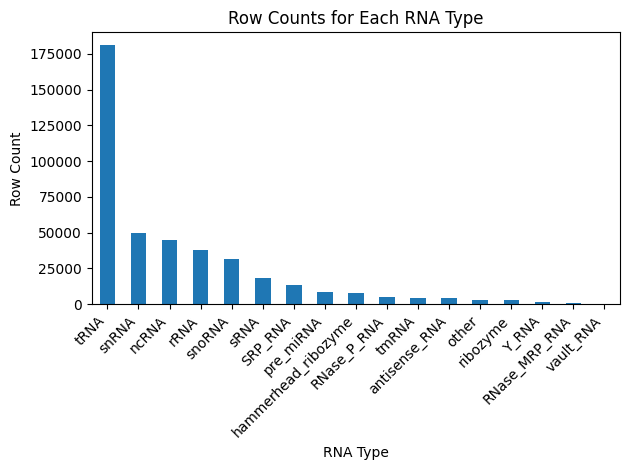

In [8]:
# Make the rna_type column categorical
rfam_df['rna_type'] = rfam_df['rna_type'].astype('category')

# Count the number of rows for each category
rna_type_counts = rfam_df['rna_type'].value_counts()

# Plot the bar chart
rna_type_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('RNA Type')
plt.ylabel('Row Count')
plt.title('Row Counts for Each RNA Type')
# Rotate x-axis labels at 45 degrees and adjust alignment
plt.xticks(rotation=45, ha='right')  # Rotate labels and align them to the right
plt.tight_layout()  # Adjust layout to prevent label cut-off
plt.show()

# Show the plot
plt.show()

### Function definition

In [9]:
def sample_dataframe(df, max_rfam_per_rna_type=5, total_rows_per_rna=300, random_seed=42, output_dir="datasets", name="sampled_dataset", special_cases=None):
    """
    Sample a DataFrame to create a subset for benchmark datasets.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    max_rfam_per_rna_type (int): Maximum RFAM families per RNA type.
    total_rows_per_rna (int): Total rows to sample per RNA type.
    random_seed (int): Random seed for reproducibility.
    output_dir (str): Directory to save the sampled DataFrame.
    name (str): Name of the sampled dataset.
    special_cases (list): List of dictionaries specifying special sampling cases.

    Returns:
    dict: A dictionary containing the sampled DataFrame and metadata.
    """
    random.seed(random_seed)
    rows_per_rfam = total_rows_per_rna // max_rfam_per_rna_type

    # Step 1: Discard rows where the rna_type count is less than 500
    rna_type_counts = df['rna_type'].value_counts()
    valid_rna_types = rna_type_counts[rna_type_counts >= 500].index
    filtered_df = df[df['rna_type'].isin(valid_rna_types)]

    # Initialize an empty list to collect sampled DataFrames
    sampled_dfs = []

    # Create a mapping for special cases
    special_cases_map = {case['rna_type']: case['rfam'] for case in (special_cases or [])}

    # Step 2: Process each rna_type separately
    for rna_type, rna_group in filtered_df.groupby('rna_type', observed=False):
        if rna_type in special_cases_map:
            # Handle special cases
            rfam_ratios = special_cases_map[rna_type]
            sampled_rows = []
            for rfam, ratio in rfam_ratios.items():
                n_samples = int(total_rows_per_rna * ratio)
                rfam_group = rna_group[rna_group['rfam'] == rfam]
                sampled_rows.append(
                    rfam_group.sample(n=min(len(rfam_group), n_samples), random_state=random_seed)
                )
            sampled_dfs.append(pd.concat(sampled_rows, ignore_index=True))
            continue

        # Calculate rfam counts within the rna_type group
        rfam_counts = rna_group['rfam'].value_counts()

        # Keep only rfam categories with enough rows for sampling
        valid_rfams = rfam_counts[rfam_counts >= rows_per_rfam]
        if valid_rfams.empty:
            # If no valid rfam categories, skip this rna_type
            continue

        # Step 2.2: Ensure we have enough rfam categories to provide the required rows
        num_rfams_needed = total_rows_per_rna // rows_per_rfam
        sorted_rfams = valid_rfams.sort_values(ascending=False)
        selected_rfams = sorted_rfams.index[:num_rfams_needed]

        # Adjust if fewer rfam categories are available
        while len(selected_rfams) < num_rfams_needed and len(sorted_rfams) > len(selected_rfams):
            selected_rfams = sorted_rfams.index[:len(selected_rfams) + 1]

        # Calculate sampling per rfam category
        rows_per_rfam_actual = total_rows_per_rna // len(selected_rfams)
        extra_rows = total_rows_per_rna % len(selected_rfams)

        # Randomly sample rows evenly distributed among the selected rfam categories
        sampled_rows = []
        for i, rfam in enumerate(selected_rfams):
            rfam_rows = rna_group[rna_group['rfam'] == rfam]
            n_sample = rows_per_rfam_actual + (1 if i < extra_rows else 0)
            sampled_rows.append(rfam_rows.sample(n=min(len(rfam_rows), n_sample), random_state=42))

        # Concatenate sampled rows for this rna_type
        sampled_dfs.append(pd.concat(sampled_rows, ignore_index=True))

    # Combine all sampled DataFrames
    sampled_df = pd.concat(sampled_dfs, ignore_index=True)

    # Determine the version number automatically
    os.makedirs(output_dir, exist_ok=True)
    existing_versions = []
    for file_name in os.listdir(output_dir):
        if file_name.startswith(name) and file_name.endswith(".tsv"):
            parts = file_name.replace(".tsv", "").split("-v")
            if len(parts) == 2 and parts[1].isdigit():
                existing_versions.append(int(parts[1]))

    version = max(existing_versions, default=0) + 1
    versioned_file_name = f"{name}-v{version}.tsv"
    output_path = os.path.join(output_dir, versioned_file_name)

    # Metadata generation
    creation_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    unique_id = str(uuid.uuid4())[:8]

    # Add metadata as a comment to the CSV
    comment_lines = [
        f"# Dataset Name: {name}",
        f"# Creation Time: {creation_time}",
        f"# Rows Sampled: {len(sampled_df)}",
        f"# Random Seed: {random_seed}",
        f"# Unique ID: {unique_id}",
        f"# Version: {version}"
    ]
    with open(output_path, 'w') as f:
        f.write("\n".join(comment_lines) + "\n")
        sampled_df.to_csv(f, index=False, sep='\t')

    metadata = {
        "name": name,
        "created_at": creation_time,
        "rows_sampled": len(sampled_df),
        "random_seed": random_seed,
        "filename": versioned_file_name,
        "unique_id": unique_id,
        "version": version
    }

    return {"sampled_df": sampled_df, "metadata": metadata}


### Sample the dataset

In [10]:
# Create the primary sampled dataset and collect its metadata
special_cases = [
    {
        "rna_type": "tRNA",
        "rfam": {
            "RF00005": 0.9,
            "RF01852": 0.1
        }
    }
]

# Generate primary sampled dataset
sampling_results = sample_dataframe(
    rfam_df,
    total_rows_per_rna=500,
    special_cases=special_cases,
    output_dir=datasets_path,  # Specify only the directory
    name="unpaired_rnas_rfam_benchmark"
)
# NOTE: We can call it primary or unpaired RNAs dataset
# Store metadata of the primary sampled dataset
primary_sampled_datasets = [sampling_results["metadata"]]


### Plot sampling summary

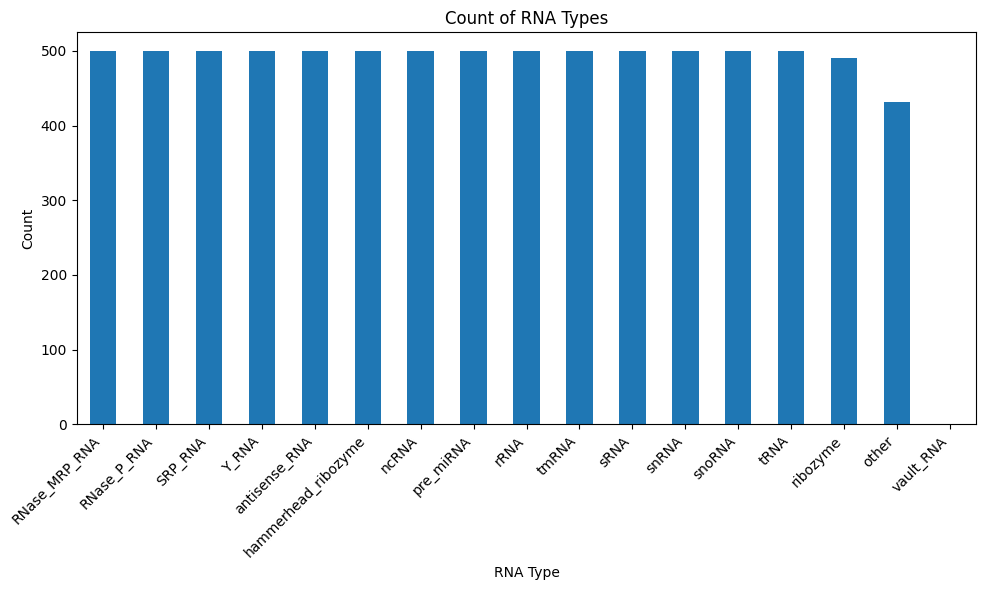

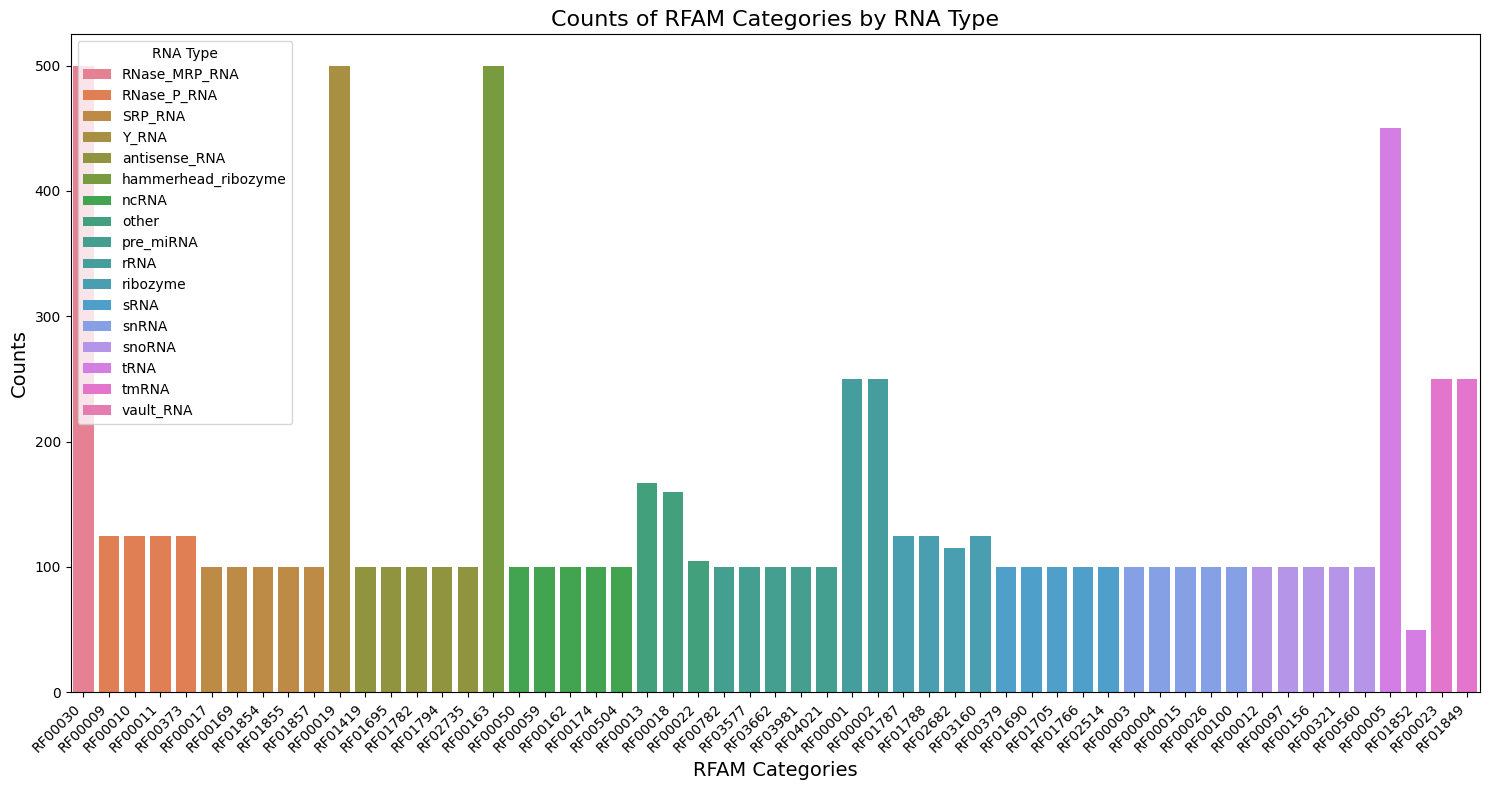

In [11]:
# Count the occurrences of each rna_type

sampled_df = sampling_results['sampled_df']

rna_type_counts = sampled_df['rna_type'].value_counts()

# Count the occurrences of each rfam
rfam_counts = sampled_df['rfam'].value_counts()

# Plot rna_type counts
plt.figure(figsize=(10, 6))
rna_type_counts.plot(kind='bar')
plt.title('Count of RNA Types')
plt.xlabel('RNA Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Calculate counts for each rfam category grouped by rna_type
rfam_counts = sampled_df.groupby(['rfam', 'rna_type'], observed=False).size().reset_index(name='count')

# Remove rows where count is zero
rfam_counts = rfam_counts[rfam_counts['count'] > 0]

# Ensure the 'rfam' column is treated as a string
rfam_counts['rfam'] = rfam_counts['rfam'].astype(str)

# Sort the DataFrame by 'rna_type' and 'rfam' to group RFAMs by RNA type
rfam_counts_sorted = rfam_counts.sort_values(['rna_type', 'rfam'])

# Create the order for the X-axis labels based on the sorted DataFrame
rfam_order = rfam_counts_sorted['rfam'].unique()

# Create the plot
plt.figure(figsize=(15, 8))
sns.barplot(
    data=rfam_counts_sorted,
    x='rfam',
    y='count',
    hue='rna_type',
    order=rfam_order,
    dodge=False  # Ensures bars for the same rfam are stacked by color
)

# Customize the plot
plt.xlabel('RFAM Categories', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.title('Counts of RFAM Categories by RNA Type', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='RNA Type', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

# Generate pairs of positive and negative RNAs (same of different RFAM/RNA type) and generate json with metadata

### Functions definition

In [12]:
def generate_pairwise_combinations(
    sampling_results, n_pairs, condition_pos, condition_neg, benchmark_name, output_dir, 
    random_seed=42, exclude_rna_types=None, description=""
):
    """
    Generate pairwise combinations and save as a benchmark dataset.

    Parameters:
    sampling_results (dict): The sampling results containing sampled DataFrame and metadata.
    n_pairs (int): Number of pairs to generate.
    condition_pos (str): Condition for positive samples.
    condition_neg (str): Condition for negative samples.
    benchmark_name (str): Name of the benchmark dataset.
    output_dir (str): Directory to save the benchmark dataset.
    random_seed (int): Random seed for reproducibility.
    exclude_rna_types (list, optional): List of RNA types to exclude from the dataset.
    description (str): Description of the benchmark dataset.

    Returns:
    dict: Metadata dictionary for the generated benchmark dataset.
    """
    sampled_df = sampling_results["sampled_df"]
    sampling_metadata = sampling_results["metadata"]

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Determine the version number automatically
    existing_versions = []
    for file_name in os.listdir(output_dir):
        if file_name.startswith(benchmark_name) and file_name.endswith(".tsv"):
            parts = file_name.replace(".tsv", "").split("-v")
            if len(parts) == 2 and parts[1].isdigit():
                existing_versions.append(int(parts[1]))

    version = max(existing_versions, default=0) + 1
    versioned_file_name = f"{benchmark_name}-v{version}.tsv"
    output_path = os.path.join(output_dir, versioned_file_name)

    np.random.seed(random_seed)

    df = sampled_df[['rnacentral_id', 'rna_type', 'rfam']]

    if exclude_rna_types:
        df = df[~df['rna_type'].isin(exclude_rna_types)]

    # Step 1: Generate all pairwise combinations
    pairs = pd.DataFrame(
        list(itertools.combinations(df.index, 2)), 
        columns=['row_1', 'row_2']
    )

    # Merge to get row values for _1 and _2
    merged = pairs.merge(df, left_on='row_1', right_index=True, suffixes=('_1', '_'))
    merged = merged.merge(df, left_on='row_2', right_index=True, suffixes=('_1', '_2'))

    # Add same_rfam and same_rna_type columns
    merged['same_rfam'] = (merged['rfam_1'] == merged['rfam_2']).astype(int)
    merged['same_rna_type'] = (merged['rna_type_1'] == merged['rna_type_2']).astype(int)

    # Step 2: Generate benchmark
    def create_benchmark(df, n_pairs, condition_pos, condition_neg):
        benchmarks = []
        for rna_type, group in df.groupby('rna_type_1', observed=False):
            # Positive samples
            positive_samples = group.query(condition_pos)
            negative_samples = group.query(condition_neg)

            # Determine the maximum possible balanced pairs
            max_samples = min(len(positive_samples), len(negative_samples))
            if max_samples == 0:
                continue

            # Adjust number of pairs to be the maximum available and balanced
            sample_size = min(max_samples, n_pairs)
            pos_sample = positive_samples.sample(n=sample_size, random_state=random_seed)
            neg_sample = negative_samples.sample(n=sample_size, random_state=random_seed)

            # Combine and append
            benchmarks.append(pd.concat([pos_sample, neg_sample], ignore_index=True))

        benchmarks_df = pd.concat(benchmarks, ignore_index=True) if benchmarks else pd.DataFrame()
        benchmarks_df.drop(columns=['row_1', 'row_2'], inplace=True)

        return benchmarks_df

    benchmark_df = create_benchmark(merged, n_pairs, condition_pos, condition_neg)

    # Generate unique ID for the benchmark dataset
    benchmark_id = str(uuid.uuid4())[:8]

    # Add metadata as comments at the top of the TSV
    comments = [
        f"# Benchmark Name: {benchmark_name}",
        f"# Benchmark ID: {benchmark_id}",
        f"# Benchmark Version: {version}",
        f"# Benchmark Creation Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
        f"# Description: {description}",
        f"# Primary Sampled Dataset ID: {sampling_metadata['unique_id']}"
    ]

    with open(output_path, 'w') as f:
        f.write("\n".join(comments) + "\n")
        benchmark_df.to_csv(f, sep="\t", index=False)

    # Add metadata
    creation_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    metadata = {
        "name": benchmark_name,
        "id": benchmark_id,
        "filename": versioned_file_name,
        "target": "same_rfam" if "same_rfam" in condition_pos else "same_rna_type",
        "n_pairs": n_pairs,
        "version": version,
        "description": description,
        "created_at": creation_time,
        "primary_sampled_dataset_id": sampling_metadata["unique_id"]
    }

    return metadata


def generate_benchmark_config(config_path, primary_sampled_datasets, benchmark_datasets):
    """
    Generate or update a JSON file for benchmark configuration.

    Parameters:
    config_path (str): Path to save the JSON configuration file.
    primary_sampled_datasets (list): List containing metadata of primary sampled datasets.
    benchmark_datasets (list): List containing metadata of benchmark datasets.
    """
    try:
        # Load existing config if it exists
        with open(config_path, 'r') as f:
            existing_config = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        # If file doesn't exist or is invalid, start with empty blocks
        existing_config = {
            "primary_sampled_datasets": [],
            "benchmark_datasets": []
        }

    # Append new primary sampled datasets and ensure no duplicates by unique_id
    existing_ids = {d["unique_id"] for d in existing_config["primary_sampled_datasets"]}
    for dataset in primary_sampled_datasets:
        if dataset["unique_id"] not in existing_ids:
            existing_config["primary_sampled_datasets"].append(dataset)

    # Append new benchmark datasets
    existing_config["benchmark_datasets"].extend(benchmark_datasets)

    # Save the updated configuration
    with open(config_path, 'w') as f:
        json.dump(existing_config, f, indent=4)

# Generate the benchmark datasets

In [13]:
# Create benchmark datasets referencing the primary sampled dataset
benchmark_datasets = []
##########################################################

################ RNA Type Classification #################

benchmark_datasets.append(generate_pairwise_combinations(
    sampling_results, 
    50, 
    "same_rna_type == 1", 
    "same_rna_type == 0 and same_rfam == 0", 
    "rna_type_benchmark_small", 
    datasets_path,  
    random_seed=42, 
    exclude_rna_types=["other"],
    description="Small benchmark dataset for RNA type classification."
))

benchmark_datasets.append(generate_pairwise_combinations(
    sampling_results, 
    1000, 
    "same_rna_type == 1", 
    "same_rna_type == 0 and same_rfam == 0", 
    "rna_type_benchmark", 
    datasets_path,  
    random_seed=42, 
    exclude_rna_types=["other"],
    description="Medium size benchmark dataset for RNA type classification."
))

benchmark_datasets.append(generate_pairwise_combinations(
    sampling_results, 
    15000, 
    "same_rna_type == 1", 
    "same_rna_type == 0 and same_rfam == 0", 
    "rna_type_benchmark_big", 
    datasets_path,  
    random_seed=42, 
    exclude_rna_types=["other"],
    description="Big benchmark dataset for RNA type classification."
))

##########################################################

################### Easy RFAM datasets ###################

benchmark_datasets.append(generate_pairwise_combinations(
    sampling_results, 
    50, 
    "same_rna_type == 1 and same_rfam == 1", 
    "same_rna_type == 0 and same_rfam == 0", 
    "easy_rfam_benchmark_small", 
    datasets_path,
    random_seed=42,
    description="Small Benchmark dataset for easy RFAM classification. Negative pairs correspond to different RNA Types."
))

benchmark_datasets.append(generate_pairwise_combinations(
    sampling_results, 
    1000, 
    "same_rna_type == 1 and same_rfam == 1", 
    "same_rna_type == 0 and same_rfam == 0", 
    "easy_rfam_benchmark", 
    datasets_path,  
    random_seed=42,
    description="Benchmark dataset for easy RFAM classification. Negative pairs correspond to different RNA Types."
))

benchmark_datasets.append(generate_pairwise_combinations(
    sampling_results, 
    15000, 
    "same_rna_type == 1 and same_rfam == 1", 
    "same_rna_type == 0 and same_rfam == 0", 
    "easy_rfam_benchmark_big", 
    datasets_path,  
    random_seed=42,
    description="Big benchmark dataset for easy RFAM classification. Negative pairs correspond to different RNA Types."
))

##########################################################

#################### Hard RFAM datasets ###################

benchmark_datasets.append(generate_pairwise_combinations(
    sampling_results, 
    50, 
    "same_rfam == 1", 
    "same_rna_type == 1 and same_rfam == 0", 
    "hard_rfam_benchmark_small", 
    datasets_path,
    random_seed=42,
    description="Small Benchmark dataset for hard RFAM classification. Negative pairs correspond to same RNA Types."
))

benchmark_datasets.append(generate_pairwise_combinations(
    sampling_results, 
    1000, 
    "same_rfam == 1", 
    "same_rna_type == 1 and same_rfam == 0", 
    "hard_rfam_benchmark", 
    datasets_path,
    random_seed=42,
    description="Benchmark dataset for hard RFAM classification. Negative pairs correspond to same RNA Types."
))

benchmark_datasets.append(generate_pairwise_combinations(
    sampling_results, 
    15000, 
    "same_rfam == 1", 
    "same_rna_type == 1 and same_rfam == 0", 
    "hard_rfam_benchmark_big", 
    datasets_path,
    random_seed=42,
    description="Big benchmark dataset for hard RFAM classification. Negative pairs correspond to same RNA Types."
))

# Generate the updated JSON configuration
generate_benchmark_config(
    datasets_path + "benchmark_datasets.json",
    primary_sampled_datasets,
    benchmark_datasets
)